In [1]:
import pints
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passi

In [2]:
import pints.toy as toy

class RescaledModel(pints.ForwardModel):
    def __init__(self):
        self.base_model = toy.LogisticModel()
    
    def simulate(self, parameters, times):
        # Run a simulation with the given parameters for the
        # given times and return the simulated values
        r, k = parameters
        r = r / 50
        k = k * 500
        return self.base_model.simulate([r, k], times)
    
    def simulateS1(self, parameters, times):
        # Run a simulation with the given parameters for the
        # given times and return the simulated values
        r, k = parameters
        r = r / 50
        k = k * 500
        return self.base_model.simulateS1([r, k], times)
    
    def n_parameters(self):
        # Return the dimension of the parameter vector
        return 2
    
model = toy.LogisticModel()
true_parameters = [0.015, 500]
start_parameters = [0.75, 1.0] # rescaled true parameters
times = np.linspace(0, 1000, 400)

In [3]:
runs = 10
n_iterations = 1000
factor = 1.05
x0 = np.array(start_parameters) * factor
sigma0 = np.array(start_parameters) * 5e-05

In [4]:
errors = []
acceptances = []
acceptances1 = []
acceptances2 = []
orig_acceptances = []

# Simulate time series
org_values = model.simulate(true_parameters, times)
range_values = max(org_values) - min(org_values)
noise = 0.05 * range_values
values = org_values + np.random.normal(0, noise, org_values.shape)

model = RescaledModel()
problem = pints.SingleOutputProblem(model, times, values)
log_likelihood = pints.GaussianKnownSigmaLogLikelihood(problem, noise)

# Create (rescaled) bounds for our parameters and get prior
bounds = pints.RectangularBoundaries([0.5, 0.8], [1.0, 1.2])
log_prior = pints.UniformLogPrior(bounds)
# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Train emulator
input_parameters = log_prior.sample(2000)
likelihoods = np.apply_along_axis(log_likelihood, 1, input_parameters)
X_train, X_valid, y_train, y_valid = train_test_split(input_parameters, likelihoods, test_size=0.3, random_state=0)
emu = pints.MultiLayerNN(problem, X_train, y_train, input_scaler=MinMaxScaler(), output_scaler=StandardScaler())
emu.set_parameters(layers=6, neurons=64, hidden_activation='relu', activation='linear', learning_rate=0.0001)
hist = emu.fit(epochs=500, batch_size=32, X_val=X_valid, y_val=y_valid, verbose=0)
log_posterior_emu = pints.LogPosterior(emu, log_prior)

for m in range(0, runs):
    
    # Run MCMC methods 
    for n in range(0, n_iterations):
        if n == 0:
            # Current point and proposed point
            current = x0
            current_log_pdf = log_posterior_emu(x0)
            true_current_log_pdf = log_posterior(x0)
            proposed = None

            # Acceptance rate and error monitoring
            error = 0
            accepted1 = 0
            accepted2 = 0
            orig_accepted = 0

            # Check initial position
            x0 = pints.vector(x0)

            # Get number of parameters
            n_parameters = len(x0)

            # Check initial standard deviation
            if sigma0 is None:
                # Get representative parameter value for each parameter
                sigma0 = np.abs(x0)
                sigma0[sigma0 == 0] = 1
                # Use to create diagonal matrix
                sigma0 = np.diag(0.01 * sigma0)
            else:
                sigma0 = np.array(sigma0)
                if np.product(sigma0.shape) == n_parameters:
                    # Convert from 1d array
                    sigma0 = sigma0.reshape((n_parameters,))
                    sigma0 = np.diag(sigma0)
                else:
                    # Check if 2d matrix of correct size
                    sigma0 = sigma0.reshape((n_parameters, n_parameters))

        # Ask- Propose new point
        #if proposed is None:
        proposed = np.random.multivariate_normal(current, sigma0)

        # Tell    
        # Calculate logpdfs
        fx = log_posterior_emu(proposed)
        true_fx = log_posterior(proposed)
        error += np.abs((true_fx - fx) / true_fx)

        # Check if the proposed point can be accepted using the emulator
        if np.isfinite(fx):
            # Step 1 - Initial reject step:
            u1 = np.log(np.random.uniform(0, 1))
            alpha1 = min(0, fx - current_log_pdf) # either alpha1 or alpha2 must be 0
            if alpha1 > u1:
                accepted1 += 1
                # Step 2 - Metropolis step:
                u2 = np.log(np.random.uniform(0, 1))
                alpha2 = min(0, current_log_pdf - fx)
                if ((true_fx + alpha1) - (true_current_log_pdf + alpha2)) > u2:
                    accepted2 += 1                 

        # Check if the proposed point can be accepted using standard MCMC
        if np.isfinite(fx):
            # Step 1 - Initial reject step:
            u = np.log(np.random.uniform(0, 1))
            if true_fx - true_current_log_pdf > u:
                orig_accepted += 1

        # Clear proposal
        proposed = None
        
    # Compute acceptance rates
    errors.append(error[0][0] / n_iterations)
    acceptances.append(accepted2 / n_iterations)
    acceptances1.append(accepted1 / n_iterations)
    acceptances2.append(accepted2 / accepted1)
    orig_acceptances.append(orig_accepted / n_iterations)


In [5]:
# Compute acceptance rates
#acceptance = accepted2 / n_iterations
#acceptance1 = accepted1 / n_iterations
#acceptance2 = accepted2 / accepted1
print("Overall:", acceptances)
print("1st-step:", acceptances1)
print("2nd-step:", acceptances2)
print("Original:", orig_acceptances)

Overall: [0.519, 0.538, 0.507, 0.505, 0.51, 0.526, 0.481, 0.511, 0.531, 0.481]
1st-step: [0.546, 0.567, 0.521, 0.526, 0.526, 0.539, 0.497, 0.534, 0.56, 0.514]
2nd-step: [0.9505494505494505, 0.9488536155202821, 0.9731285988483686, 0.9600760456273765, 0.9695817490494296, 0.9758812615955473, 0.9678068410462777, 0.9569288389513109, 0.9482142857142857, 0.9357976653696498]
Original: [0.508, 0.526, 0.489, 0.492, 0.497, 0.517, 0.468, 0.499, 0.517, 0.468]


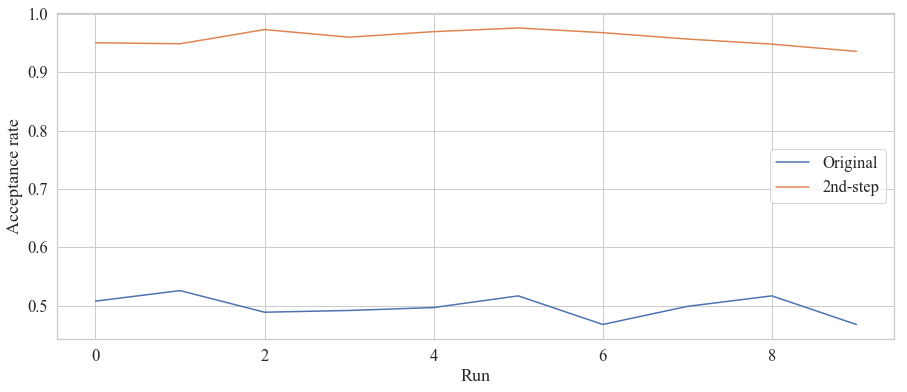

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='notebook', style='whitegrid', palette='deep', font='Times New Roman', 
        font_scale=1.5, color_codes=True, rc={"grid.linewidth": 1})

fig, ax = plt.subplots(figsize=(15,6))
plt.xlabel('Run')
plt.ylabel('Acceptance rate')
ax.plot(orig_acceptances, label='Original')
ax.plot(acceptances2, label='2nd-step')
plt.legend()
plt.show()

fig.savefig("figures/simulations/acceptances-"+str(factor)+".png", bbox_inches='tight', dpi=200)

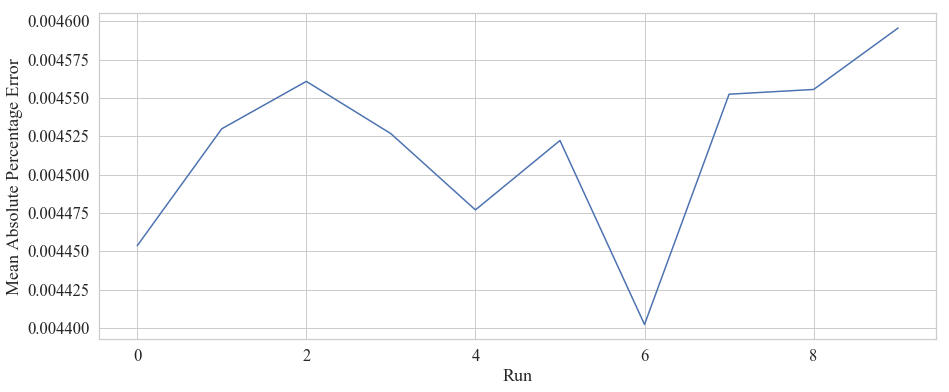

In [7]:
#errors = [e[0][0] for e in errors]

fig, ax = plt.subplots(figsize=(15,6))
plt.xlabel('Run')
plt.ylabel('Mean Absolute Percentage Error')
ax.plot(errors)
plt.show()

fig.savefig("figures/simulations/errors-"+str(factor)+".png", bbox_inches='tight', dpi=200)

In [8]:
sum([acc>orig for (acc,orig) in zip(acceptances2, orig_acceptances)])

10